# Surfacing Promotions M2

In [1]:
import dotenv
import matplotlib.pyplot as plt
import numpy as np
import os 
import pandas as pd
import seaborn as sns
import sys
import trino

src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(src_path)

from glovo_experimentation_analytics.analytics.experiment import Experiment 
from long_term_exp_impact import make_inference
from long_term_exp_impact.config import METRICS
from long_term_exp_impact.load_data import get_harmony_data, agg_harmony_data, create_metrics_query_config, _get_starburst_engine
from long_term_exp_impact.inference import add_metrics_at_unit_level, get_metrics_point_estimates
from long_term_exp_impact.metric import parse_metrics
from src import query_engines, dataframe_visualizer

q = query_engines.QueryEngines()

/Users/jordicremades/Documents/repos/central-node/venvs/venv_glovo_experimentation_analytics/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Q1: What are the different experiment ids

In [2]:
QUERY_NAME = 'experiments.sql' # With sql
START_DATE = "'2024-07-01'"
END_DATE = "'2024-12-02'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
    
)

df  = q.query_run_starburst()
df

,experiment_toggle_id,experiment_id,first_exposure_date
0,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10060-ZAP_SURFACING_PROMO...,2024-07-01
1,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10715-ZAP_SURFACING_PROMO...,2024-07-04
2,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-10715-ZAP_SURFACING_PROMO...,2024-07-04
3,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11134-ZAP_SURFACING_PROMO...,2024-07-18
4,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11986-ZAP_SURFACING_PROMO...,2024-08-19
5,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-11986-ZAP_SURFACING_PROMO...,2024-08-26
6,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12294-ZAP_SURFACING_PROMO...,2024-09-03
7,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12327-ZAP_SURFACING_PROMO...,2024-09-05
8,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12371-ZAP_SURFACING_PROMO...,2024-09-06
9,ZAP_SURFACING_PROMOS,ZAP_SURFACING_PROMOS-12371-ZAP_SURFACING_PROMO...,2024-09-17


In [29]:
df['experiment_id'].iloc[11]

'ZAP_SURFACING_PROMOS-13539-ZAP_SURFACING_PROMOS_FF-13490'

# Q2: Check the evolution of variants

In [3]:
QUERY_NAME = 'exposures.sql' # With sql
START_DATE = "'2024-10-01'"
END_DATE = "'2024-12-02'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
    
)

df  = q.query_run_starburst()
df.head()

,customer_id,variant,first_exposure_at
0,147880227,Promotions enabled,2024-11-05
1,33090732,Promotions enabled,2024-10-30
2,65101950,Promotions enabled,2024-11-02
3,165790772,Control Group,2024-11-04
4,39608188,Promotions enabled,2024-11-02


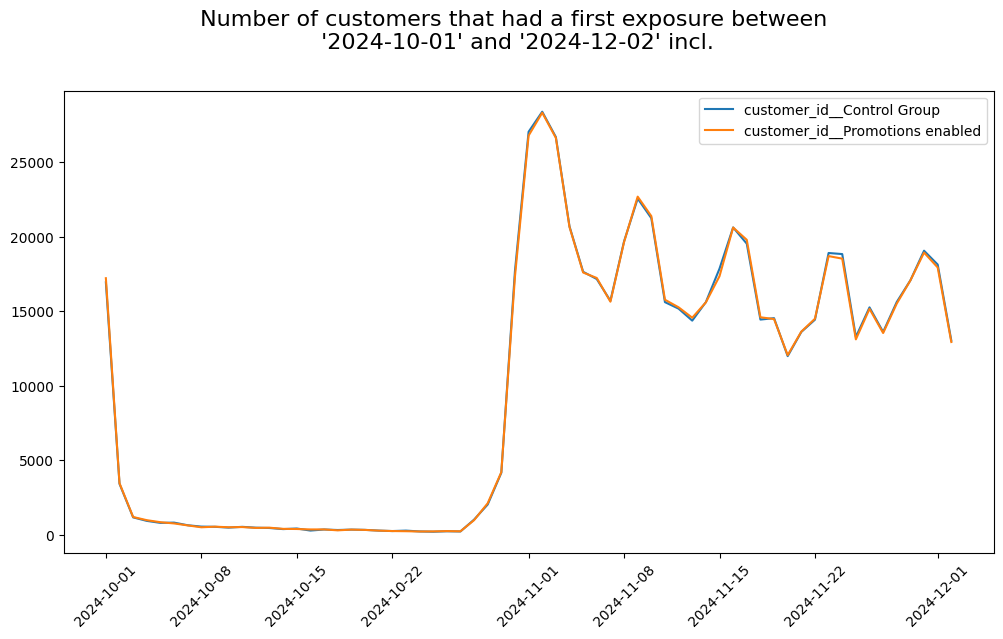

In [4]:
tmp = df.copy()

tmp['first_exposure_at'] = pd.to_datetime(tmp['first_exposure_at'])
grouped = tmp.groupby(['first_exposure_at','variant'])['customer_id'].nunique().reset_index()
grouped.sort_values(by=['first_exposure_at','variant'],ascending=[True,True], inplace=True)
pivot = grouped.pivot(index = 'first_exposure_at', columns='variant', values=['customer_id'])
pivot.columns = [f'{col[0]}__{col[1]}' for col in pivot.columns]
pivot = pivot.reset_index()
pivot = pivot.fillna(0)

v = dataframe_visualizer.DataFrameVisualizer(pivot)

plot_params = [
    {
        'plot_type': 'lineplot', 
        'x_column': 'first_exposure_at', 
        'y_columns': ['customer_id__Control Group', 'customer_id__Promotions enabled'],
        'colors': ['blue', 'orange'],
        'legend': True
    }
]

figure_params = {
    'n_plots': 1,
    'fig_length': 12,
    'fig_height': 6, 
    'x_rotation': 45,
    'x_limits': None, 
    'y_limits': None, 
    'title': f' Number of customers that had a first exposure between \n {START_DATE} and {END_DATE} incl.'
}

v.plot(figure_params=figure_params, plot_params=plot_params)


In [40]:
pivot['first_exposure_at'] = pd.to_datetime(pivot['first_exposure_at'])
cond = pivot['first_exposure_at'] > '2024-10-20'
pivot[cond]

,first_exposure_at,customer_id__Control Group,customer_id__Promotions enabled
20,2024-10-21,294,293
21,2024-10-22,264,264
22,2024-10-23,294,253
23,2024-10-24,238,235
24,2024-10-25,219,240
25,2024-10-26,249,260
26,2024-10-27,235,246
27,2024-10-28,1029,992
28,2024-10-29,2043,2127
29,2024-10-30,4172,4211


# Q3: Harmony metric

In [11]:
dotenv.load_dotenv()
conn = _get_starburst_engine()

In [46]:
exp_exposures_sql_path = "queries/exposures_harmony.sql"
exp_exposures_sql_config = {
    'end_date':"2024-11-24",
    'num_days':27
}

exp_metrics_query_config = create_metrics_query_config(
    end_date="2024-11-24",
    num_days=27,
    city_codes="all"
)

In [47]:
exp_df = get_harmony_data(
    conn=conn,
    exposures_sql_path=exp_exposures_sql_path,
    exposure_sql_config=exp_exposures_sql_config,
    metrics_query_config=exp_metrics_query_config
)

Started collecting data for harmony metrics ...
Started collecting data for customer exposures using your query ...
Started processing the data to create the final dataset for analysis ...
Loading data is completed.


In [48]:
exp_df_agg = exp_df.pipe(agg_harmony_data, groupby_cols=('customer_id','variant'))

print(exp_df_agg.shape)
exp_df_agg.head()

(864093, 14)


,customer_id,variant,total_orders_cancelled,total_orders_delivered,total_dt_minutes,total_cdt_minutes,total_orders_created,total_long_orders,total_late_orders,total_cpo,total_cm,total_ads_revenue,total_delivered_orders_eta,one
0,223,Promotions enabled,1.0,11.0,299.350000,199.350000,12.0,0.0,1.0,33.53815,10.378454,0.000000,11.0,1
1,273,Promotions enabled,0.0,3.0,67.866667,37.000000,3.0,0.0,0.0,9.53630,-47.835400,1.132002,3.0,1
2,287,Promotions enabled,0.0,10.0,263.316667,159.791667,10.0,0.0,0.0,24.25410,65.461500,0.000000,9.0,1
3,296,Promotions enabled,0.0,3.0,108.233333,69.916667,3.0,1.0,0.0,6.21120,13.953700,1.045617,2.0,1
4,301,Promotions enabled,0.0,8.0,234.600000,64.247222,8.0,0.0,1.0,13.07755,25.500022,2.091234,8.0,1


In [49]:
variant_map = {
    "Control Group": "control",
    "Promotions enabled": "treatment"
}

exp_df_agg['variant'] = exp_df_agg['variant'].map(variant_map)

In [50]:
alpha=0.1

results = make_inference(
    df=exp_df_agg,
    alpha=alpha
)

results

{'estimand': 'relative effect on 1y CM',
 'point_estimate': -0.006262541738420772,
 'ci_low': -0.017062079947792966,
 'ci_upp': 0.004536996470951422,
 'std_err': 0.006565653035880021,
 'alpha': 0.1,
 'n_largest': 432301}

In [51]:
proxy_results = get_metrics_point_estimates(add_metrics_at_unit_level(exp_df_agg, parse_metrics(METRICS)))

proxy_results

{'m_cancellation_rate': {'control': 0.030578227335405054,
  'treatment': 0.030590969367273277},
 'm_customer_dt': {'control': 33.74142915253867,
  'treatment': 33.791872080277706},
 'm_courier_dt': {'control': 16.60607124214159,
  'treatment': 16.614269935472727},
 'm_orders_created': {'control': 3.5287427047358206,
  'treatment': 3.537710286434209},
 'm_long_orders_rate': {'control': 0.06882527296706925,
  'treatment': 0.06925927891258019},
 'm_late_orders_rate': {'control': 0.043192613473540725,
  'treatment': 0.04341928936980517},
 'm_cpo': {'control': 2.5292298642307034, 'treatment': 2.5317304668500493},
 'm_cm': {'control': 4.303407310293273, 'treatment': 4.263320822742625},
 'm_ads': {'control': 0.9408981745656686, 'treatment': 0.9428049775816181},
 'units': {'control': 432301, 'treatment': 431792}}

# Q4: Order level metrics

In [5]:
QUERY_NAME = 'metrics_orders_customer_level.sql' # With sql
START_DATE = "'2024-10-28'"
END_DATE = "'2024-11-24'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
    
)

df  = q.query_run_starburst()
df

,customer_id,variant,first_exposure_at,groceries_delivered_orders,groceries_total_gmv,check_groceries_delivered_orders,groceries_delivered_orders_with_discounts,groceries_gmv_from_discounted_products
0,177738363,Control Group,2024-11-03,1,2.608128,1,0,0.00
1,27178754,Control Group,2024-11-08,0,0.000000,0,0,0.00
2,12219406,Control Group,2024-11-10,0,0.000000,0,0,0.00
3,8911824,Control Group,2024-11-11,1,32.470000,1,0,0.00
4,26611332,Promotions enabled,2024-11-24,0,0.000000,0,0,0.00
...,...,...,...,...,...,...,...,...
958416,82869370,Control Group,2024-11-13,0,0.000000,0,0,0.00
958417,55954552,Promotions enabled,2024-11-16,0,0.000000,0,0,0.00
958418,46962093,Promotions enabled,2024-11-17,1,22.630000,1,0,0.00
958419,132794747,Promotions enabled,2024-11-08,0,0.000000,0,0,0.00


## All dataset

In [7]:
# Customer split
df.groupby('variant')[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df['customer_id'].nunique())

,customer_id,perc
,nunique,
variant,,
Control Group,479527,0.50033
Promotions enabled,478894,0.49967


In [8]:
df['perc_gmv_from_discounts'] = df['groceries_gmv_from_discounted_products']/df['groceries_total_gmv']
df['perc_gmv_from_discounts'] = df['perc_gmv_from_discounts'].fillna(0)

df['aov'] = df['groceries_total_gmv']/df['groceries_delivered_orders']
df['aov'] = df['aov'].fillna(0)

In [10]:
# Check for a specific metric
METRIC_NAME = 'groceries_delivered_orders'

unique_customers = df.groupby('variant')['customer_id'].nunique()
metric = df.groupby('variant')[METRIC_NAME].sum()

result = metric / unique_customers
result_df = result.reset_index(name='metric')
result_df

,variant,metric
0,Control Group,0.921104
1,Promotions enabled,0.923175


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃              ┃              ┃               ┃              ┃               ┃             ┃       ┃        Alpha ┃
┃ Name         ┃ Hypothesis   ┃          Date ┃      Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing    │ New          │ 2024-10-26 to │  ['Groceries │     ['Control │        True │  0.05 │       0.0083 │
│ promos for   │ surfacing    │    2024-11-22 │    delivered │       Group', │             │       │              │
│ Groceries    │ promotions   │               │     orders', │   'Promotions │             │       │              │
│              │ will         │               │   'Groceries │     enabled'] │             │       │              │
│              │ increase the │               │    delivered │               │             │       │              │
│              │ number of    │               │  orders with │               │             │       │              │
│              │ customers    │               │  discounts', │               │             │       │              │
│              │ that         │               │   'Groceries │               │             │       │              │
│              │ interact     │               │  total GMV', │               │             │       │              │
│              │ with         │               │   'Groceries │               │             │       │              │
│              │ Promotions   │               │     GMV from │               │             │       │              │
│              │              │               │   discounted │               │             │       │              │
│              │              │               │   products', │               │             │       │              │
│              │              │               │   'Groceries │               │             │       │              │
│              │              │               │    delivered │               │             │       │              │
│              │              │               │    AOV Eur', │               │             │       │              │
│              │              │               │  'Percentage │               │             │       │              │
│              │              │               │     GMV from │               │             │       │              │
│              │              │               │  Discounts'] │               │             │       │              │
└──────────────┴──────────────┴───────────────┴──────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED ORDERS                                                                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.921104,0.923175,0.002072,-0.009604,0.013748,0.639727,0.004426,False


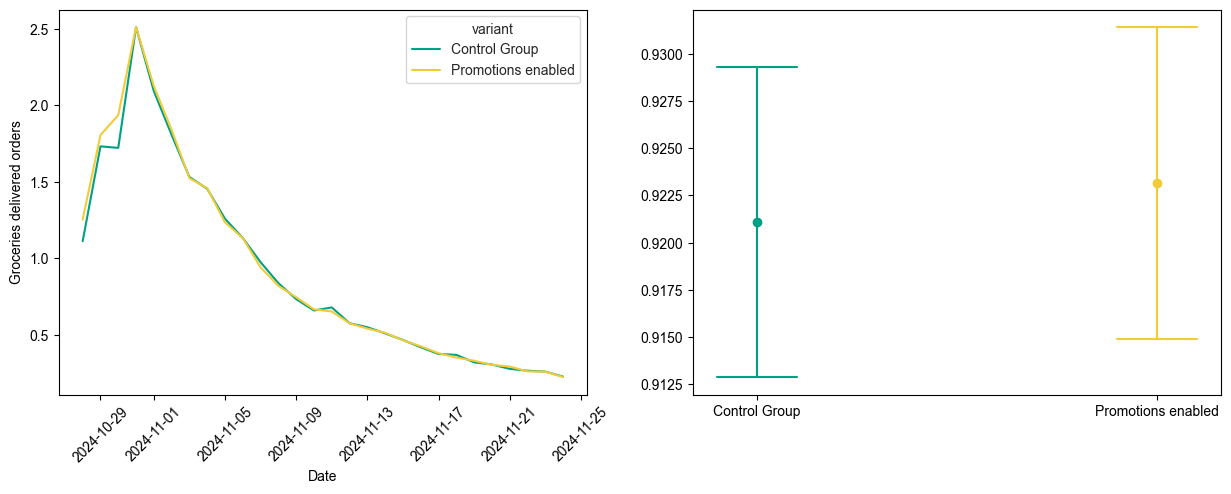

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED ORDERS WITH DISCOUNTS                                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.300815,0.312959,0.012143,0.007159,0.017127,1.293483e-10,0.001889,True


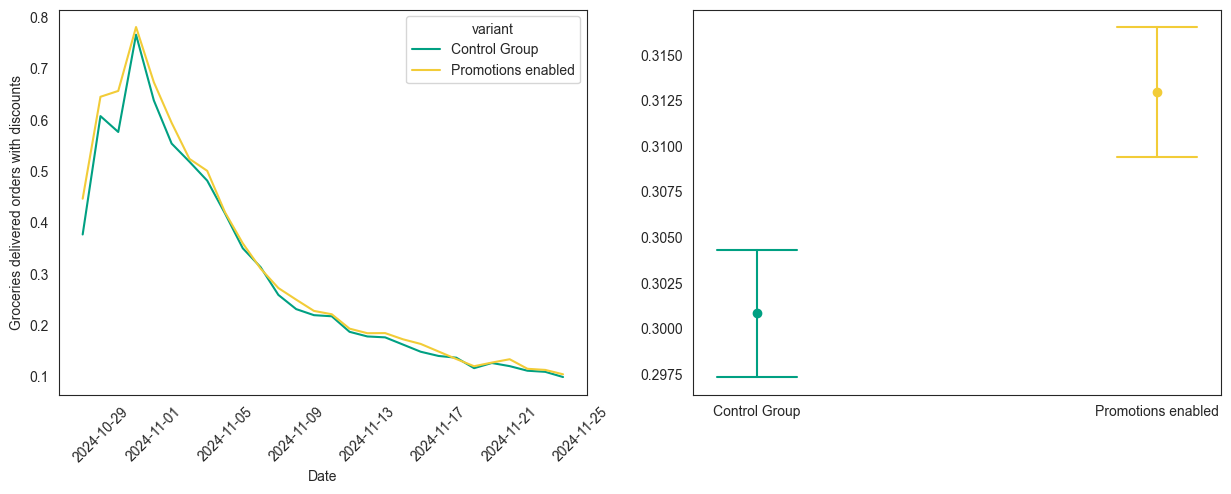

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES TOTAL GMV                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,17.046788,16.998682,-0.048107,-0.295294,0.19908,0.607637,0.093693,False


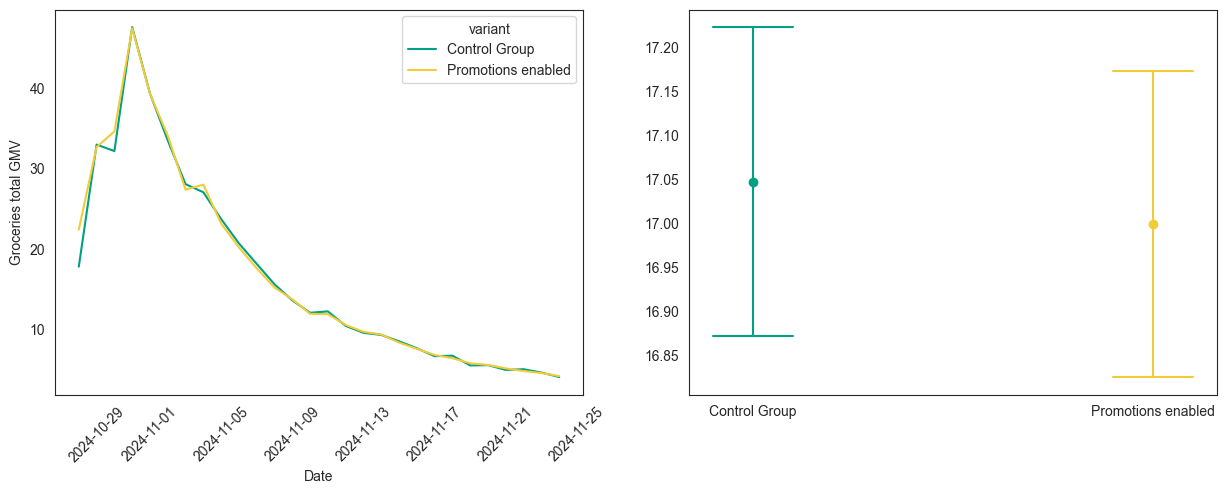

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES GMV FROM DISCOUNTED PRODUCTS                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,1.971085,2.061548,0.090463,0.047829,0.133097,2.169661e-08,0.01616,True


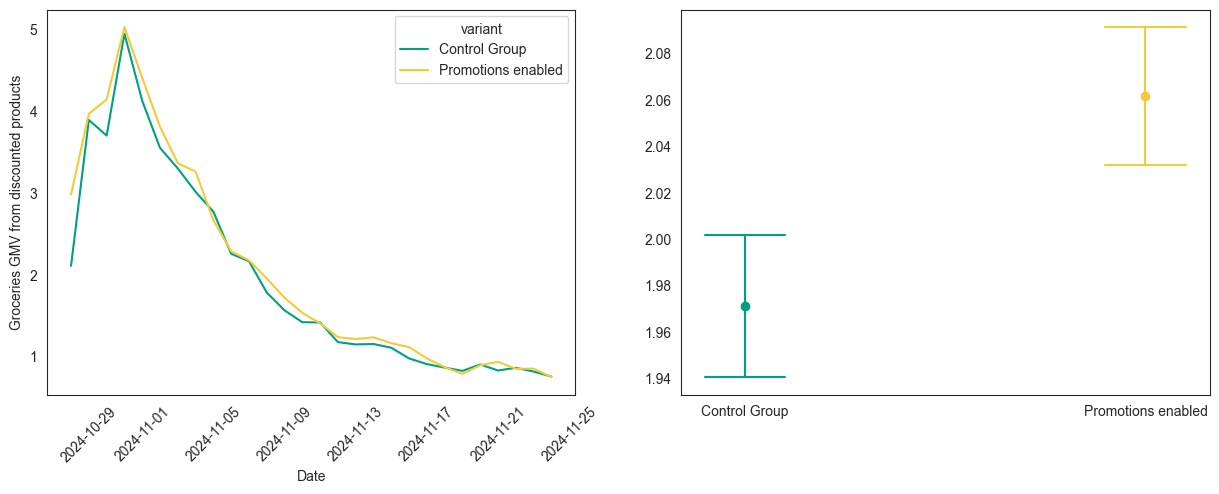

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED AOV EUR                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,6.828886,6.832543,0.003658,-0.0641,0.071416,0.886754,0.025683,False


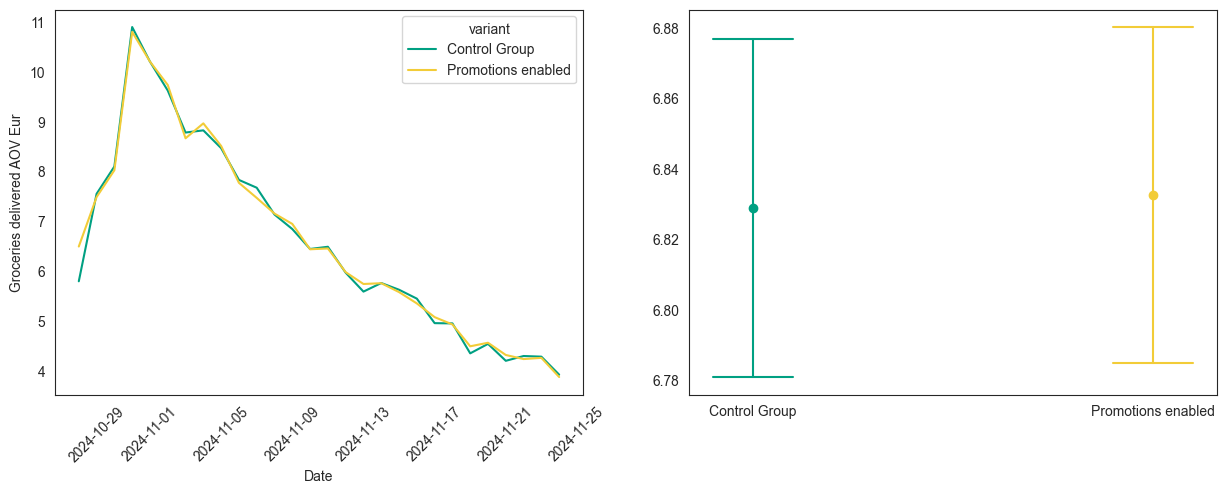

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ PERCENTAGE GMV FROM DISCOUNTS                                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.044722,0.047601,0.002879,0.002118,0.003639,1.682091e-23,0.000288,True


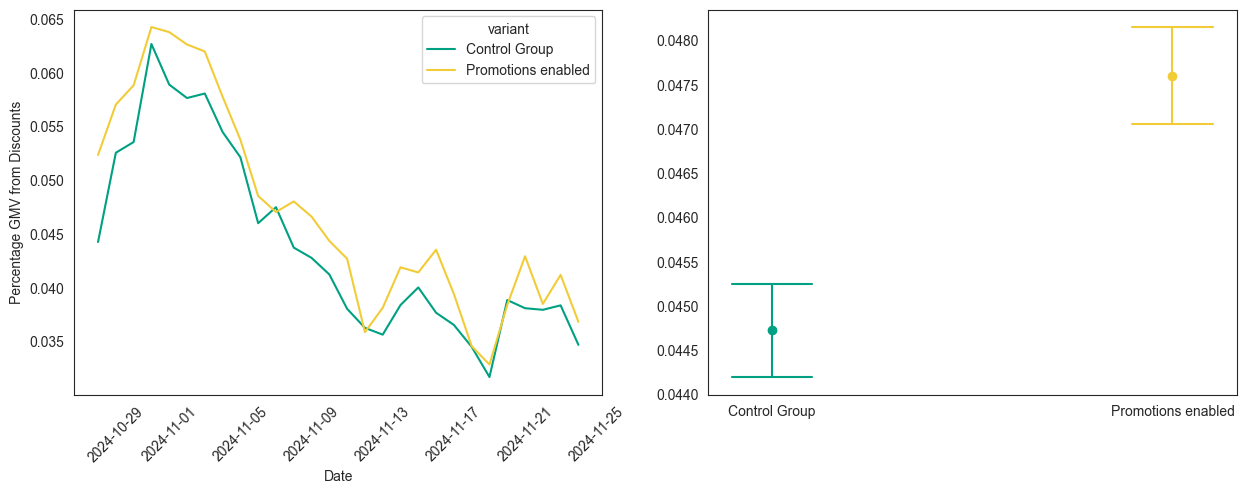

In [12]:
from glovo_experimentation_analytics.analytics.experiment import Experiment

df['date'] = pd.to_datetime(df['first_exposure_at'])


experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "New surfacing promotions will increase the number of customers that interact with Promotions",
        "start_date": "2024-10-26",
        "end_date": "2024-11-22",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Groceries delivered orders",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_orders",
            },   
            {
                "metric_name": "Groceries delivered orders with discounts",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_orders_with_discounts",
            },
            {
                "metric_name": "Groceries total GMV",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_total_gmv",
            },  
            {
                "metric_name": "Groceries GMV from discounted products",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_gmv_from_discounted_products",
            },   
            {
                "metric_name": "Groceries delivered AOV Eur",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "aov",
            },   
            {
                "metric_name": "Percentage GMV from Discounts",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "perc_gmv_from_discounts",
            },   
        ],    
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": True
    }

exp_fin = Experiment.from_dict(experiment_config)
exp_fin.full_analysis()

## Only Customers with orders

In [15]:
cond = df['groceries_delivered_orders'] > 0
df_with_ordres = df[cond].copy()

In [16]:
# Customer split
df_with_ordres.groupby('variant')[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df_with_ordres['customer_id'].nunique())

,customer_id,perc
,nunique,
variant,,
Control Group,178187,0.499957
Promotions enabled,178218,0.500043


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃              ┃              ┃               ┃              ┃               ┃             ┃       ┃        Alpha ┃
┃ Name         ┃ Hypothesis   ┃          Date ┃      Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing    │ New          │ 2024-10-26 to │  ['Groceries │     ['Control │        True │  0.05 │       0.0083 │
│ promos for   │ surfacing    │    2024-11-22 │    delivered │       Group', │             │       │              │
│ Groceries    │ promotions   │               │     orders', │   'Promotions │             │       │              │
│              │ will         │               │   'Groceries │     enabled'] │             │       │              │
│              │ increase the │               │    delivered │               │             │       │              │
│              │ number of    │               │  orders with │               │             │       │              │
│              │ customers    │               │  discounts', │               │             │       │              │
│              │ that         │               │   'Groceries │               │             │       │              │
│              │ interact     │               │  total GMV', │               │             │       │              │
│              │ with         │               │   'Groceries │               │             │       │              │
│              │ Promotions   │               │     GMV from │               │             │       │              │
│              │              │               │   discounted │               │             │       │              │
│              │              │               │   products', │               │             │       │              │
│              │              │               │   'Groceries │               │             │       │              │
│              │              │               │    delivered │               │             │       │              │
│              │              │               │    AOV Eur', │               │             │       │              │
│              │              │               │  'Percentage │               │             │       │              │
│              │              │               │     GMV from │               │             │       │              │
│              │              │               │  Discounts'] │               │             │       │              │
└──────────────┴──────────────┴───────────────┴──────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED ORDERS                                                                                      │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,2.478823,2.480687,0.001864,-0.024292,0.02802,0.850882,0.009914,False


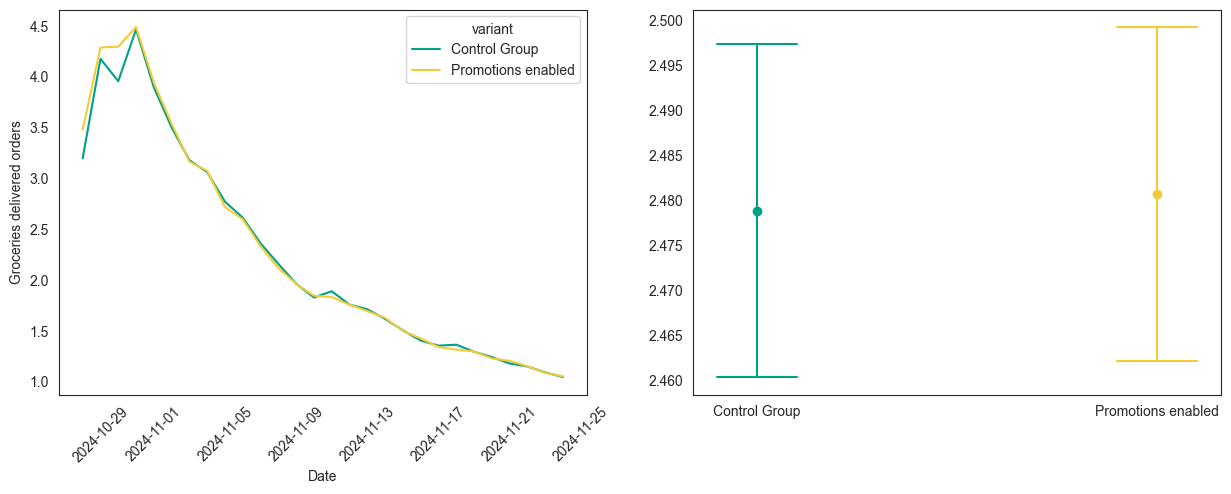

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED ORDERS WITH DISCOUNTS                                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.809537,0.840959,0.031422,0.01933,0.043513,7.093120e-12,0.004583,True


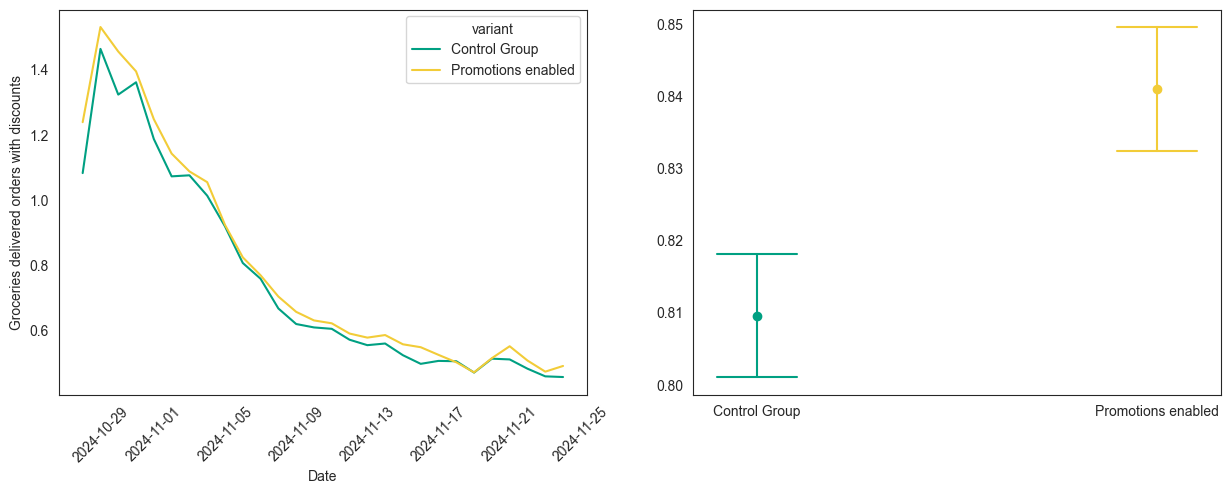

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES TOTAL GMV                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,45.875374,45.677579,-0.197796,-0.780066,0.384474,0.370139,0.220701,False


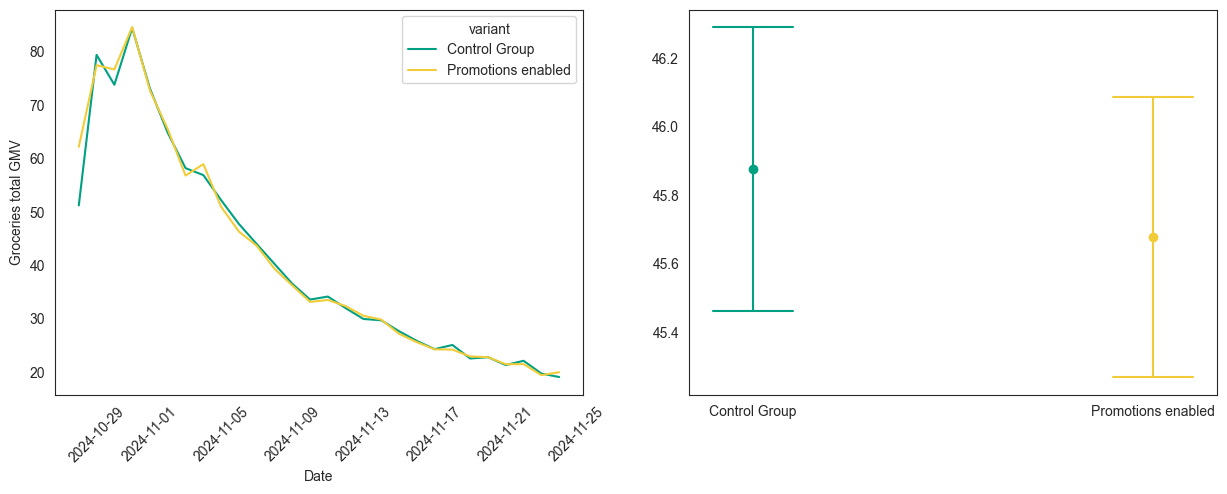

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES GMV FROM DISCOUNTED PRODUCTS                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,5.304474,5.539636,0.235162,0.126986,0.343337,9.741348e-09,0.041002,True


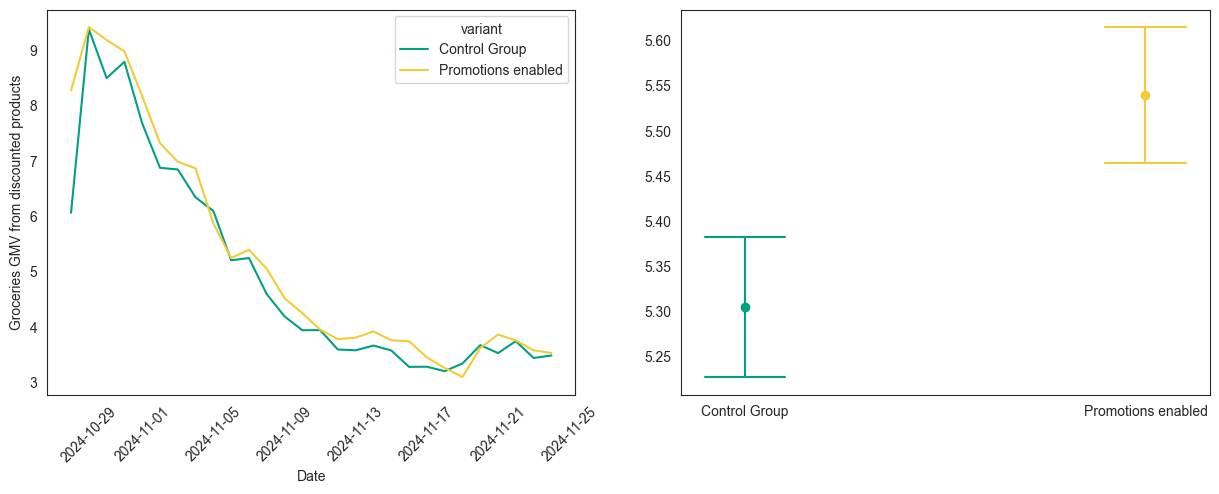

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ GROCERIES DELIVERED AOV EUR                                                                                     │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,18.37752,18.359897,-0.017623,-0.146638,0.111392,0.718559,0.048901,False


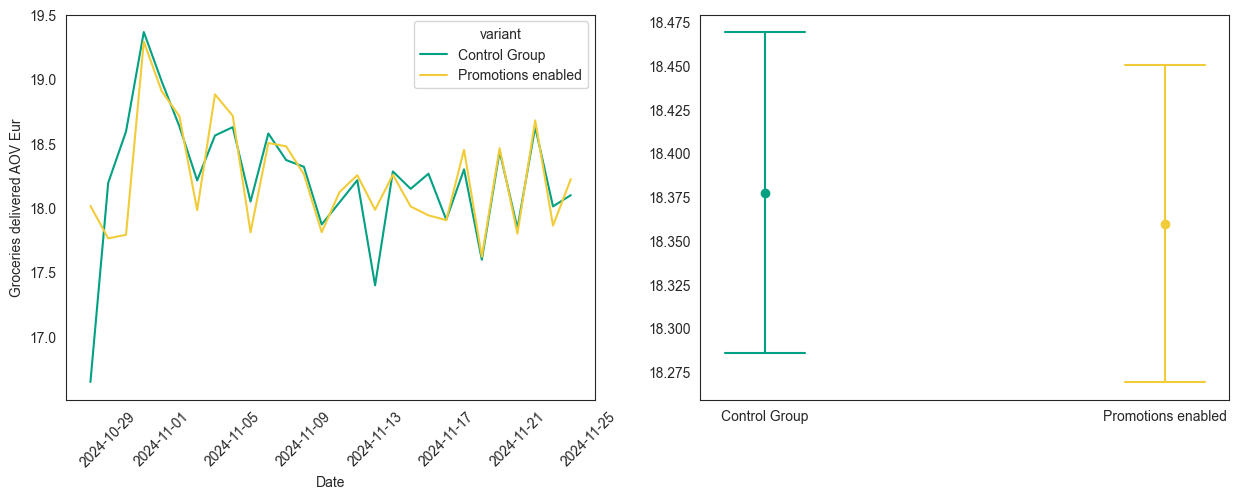

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ PERCENTAGE GMV FROM DISCOUNTS                                                                                   │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.120354,0.12791,0.007555,0.005706,0.009405,4.525106e-27,0.000701,True


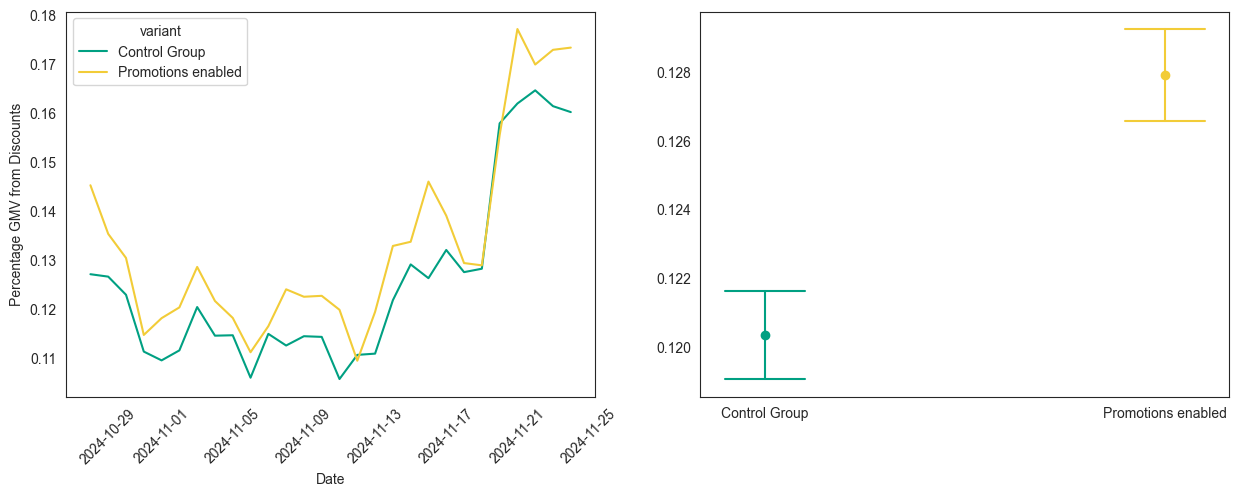

In [17]:
from glovo_experimentation_analytics.analytics.experiment import Experiment

df_with_ordres['date'] = pd.to_datetime(df_with_ordres['first_exposure_at'])


experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "New surfacing promotions will increase the number of customers that interact with Promotions",
        "start_date": "2024-10-26",
        "end_date": "2024-11-22",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Groceries delivered orders",
                "df": df_with_ordres,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_orders",
            },   
            {
                "metric_name": "Groceries delivered orders with discounts",
                "df": df_with_ordres,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_delivered_orders_with_discounts",
            },
            {
                "metric_name": "Groceries total GMV",
                "df": df_with_ordres,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_total_gmv",
            },  
            {
                "metric_name": "Groceries GMV from discounted products",
                "df": df_with_ordres,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "groceries_gmv_from_discounted_products",
            },   
            {
                "metric_name": "Groceries delivered AOV Eur",
                "df": df_with_ordres,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "aov",
            },   
            {
                "metric_name": "Percentage GMV from Discounts",
                "df": df_with_ordres,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "perc_gmv_from_discounts",
            },   
        ],    
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": True
    }

exp_fin = Experiment.from_dict(experiment_config)
exp_fin.full_analysis()

# Q5: Session level metrics

In [18]:
QUERY_NAME = 'metrics_sessions_customer_level.sql' # With sql
START_DATE = "'2024-10-28'"
END_DATE = "'2024-11-24'"

params = [
    {'name':'start_date', 'value': str(START_DATE)},
    {'name':'end_date', 'value': str(END_DATE)}
]

q.prepare_query(
    QUERY_NAME
    ,params=params
    ,to_load_file=QUERY_NAME
    ,load_from_to_load_file=QUERY_NAME
)

df  = q.query_run_starburst()
df

,customer_id,variant,first_exposure_at,banner_impressions,distinct_banner_impressions_per_session,widget_collection_impressions,collection_opened,distinct_collection_opened_per_session,store_access_session,order_created_session
0,19056379,Promotions enabled,2024-11-05,0,0,0,0,0,2,0
1,134756641,Control Group,2024-11-05,42,17,0,79,56,14,9
2,39995464,Control Group,2024-11-01,32,13,0,118,87,13,6
3,177981046,Control Group,2024-11-21,1,1,0,29,20,1,0
4,31796901,Promotions enabled,2024-11-01,8,3,16,46,33,5,3
...,...,...,...,...,...,...,...,...,...,...
958416,27572861,Promotions enabled,2024-11-09,0,0,0,0,0,1,1
958417,146854835,Promotions enabled,2024-11-02,6,2,16,29,23,1,0
958418,180614320,Control Group,2024-11-03,0,0,0,0,0,1,0
958419,15065897,Promotions enabled,2024-11-24,0,0,0,2,2,1,1


## All dataset

In [21]:
# Customer split
df.groupby('variant')[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df['customer_id'].nunique())

,customer_id,perc
,nunique,
variant,,
Control Group,479527,0.50033
Promotions enabled,478894,0.49967


In [24]:
df['cvr'] = df['order_created_session']/df['store_access_session']
df['cvr'] = df['cvr'].fillna(0)

In [27]:
METRIC_NAME = 'widget_collection_impressions'

unique_customers = df.groupby('variant')['customer_id'].nunique()
groceries_with_discounts = df.groupby('variant')[METRIC_NAME].sum()

result = groceries_with_discounts / unique_customers
result_df = result.reset_index(name='metric')
result_df

,variant,metric
0,Control Group,0.000311
1,Promotions enabled,4.842159


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃              ┃              ┃               ┃              ┃               ┃             ┃       ┃        Alpha ┃
┃ Name         ┃ Hypothesis   ┃          Date ┃      Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing    │ New          │ 2024-07-04 to │ ['Collectio… │     ['Control │        True │  0.05 │       0.0083 │
│ promos for   │ surfacing    │    2024-08-16 │ impressions… │       Group', │             │       │              │
│ Groceries    │ promotions   │               │    'Distinct │   'Promotions │             │       │              │
│              │ will         │               │ Collection_… │     enabled'] │             │       │              │
│              │ increase the │               │  impressions │               │             │       │              │
│              │ number of    │               │          per │               │             │       │              │
│              │ customers    │               │    session', │               │             │       │              │
│              │ that         │               │      'Widget │               │             │       │              │
│              │ interact     │               │   collection │               │             │       │              │
│              │ with         │               │ impresions', │               │             │       │              │
│              │ Promotions   │               │  'Collection │               │             │       │              │
│              │              │               │     opened', │               │             │       │              │
│              │              │               │    'Distinct │               │             │       │              │
│              │              │               │   collection │               │             │       │              │
│              │              │               │   opened per │               │             │       │              │
│              │              │               │    session', │               │             │       │              │
│              │              │               │       'CVR'] │               │             │       │              │
└──────────────┴──────────────┴───────────────┴──────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ COLLECTION_SHOPPABLE_BANNER IMPRESSIONS                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,2.976598,2.956719,-0.019879,-0.069981,0.030223,0.295204,0.01899,False


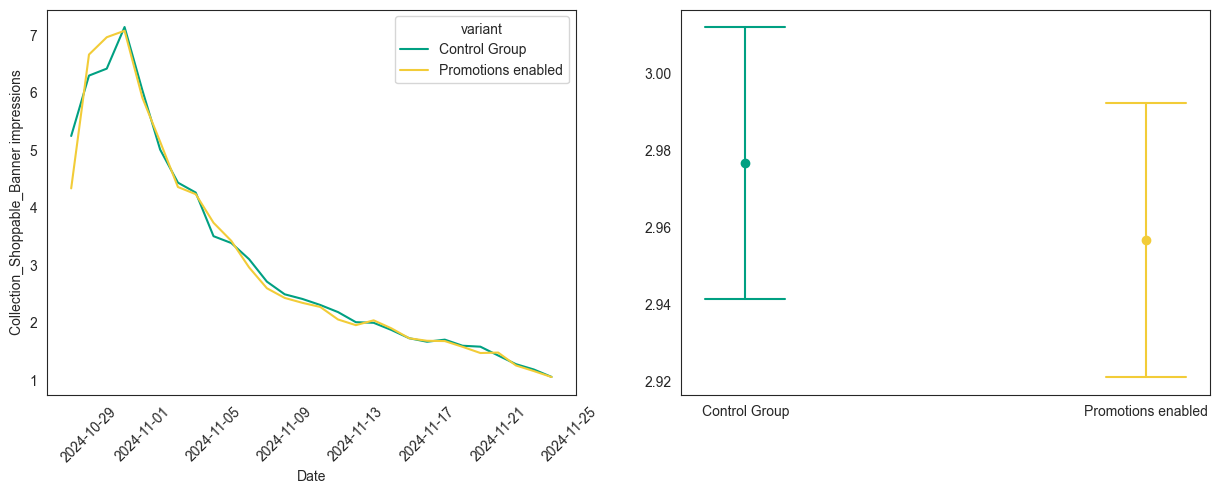

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DISTINCT COLLECTION_SHOPPABLE_BANNER IMPRESSIONS PER SESSION                                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,1.321534,1.320067,-0.001467,-0.020593,0.017659,0.839651,0.007249,False


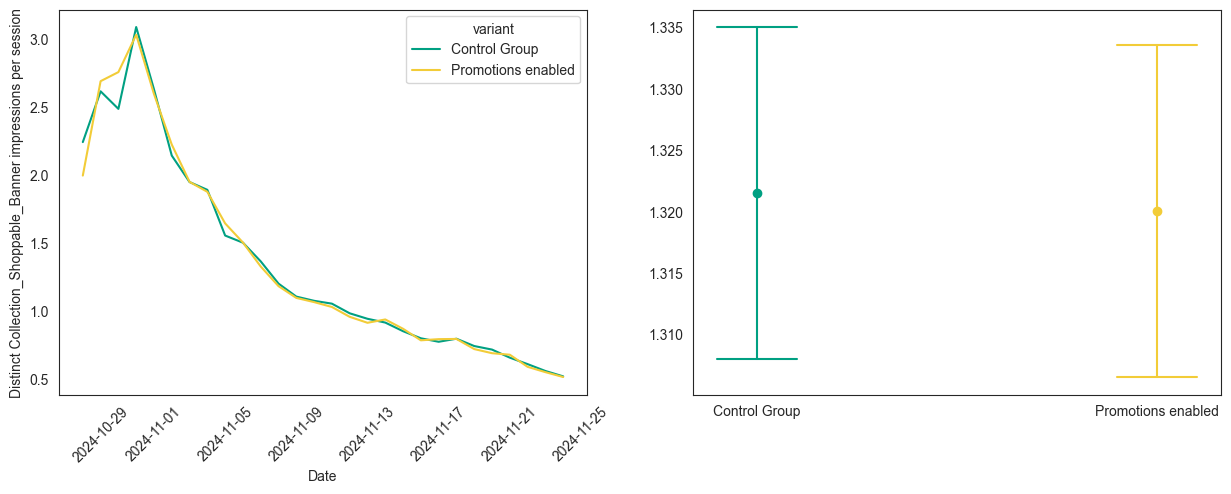

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ WIDGET COLLECTION IMPRESIONS                                                                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.000311,4.842159,4.841849,4.787896,4.895801,0.0,0.02045,True


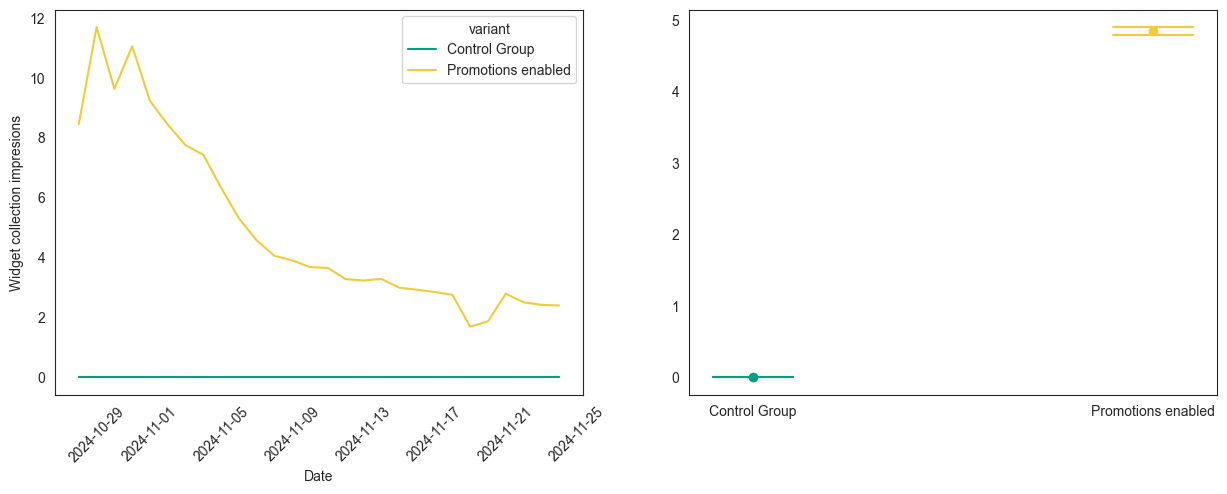

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ COLLECTION OPENED                                                                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,13.426141,13.420392,-0.005749,-0.191344,0.179846,0.934865,0.070347,False


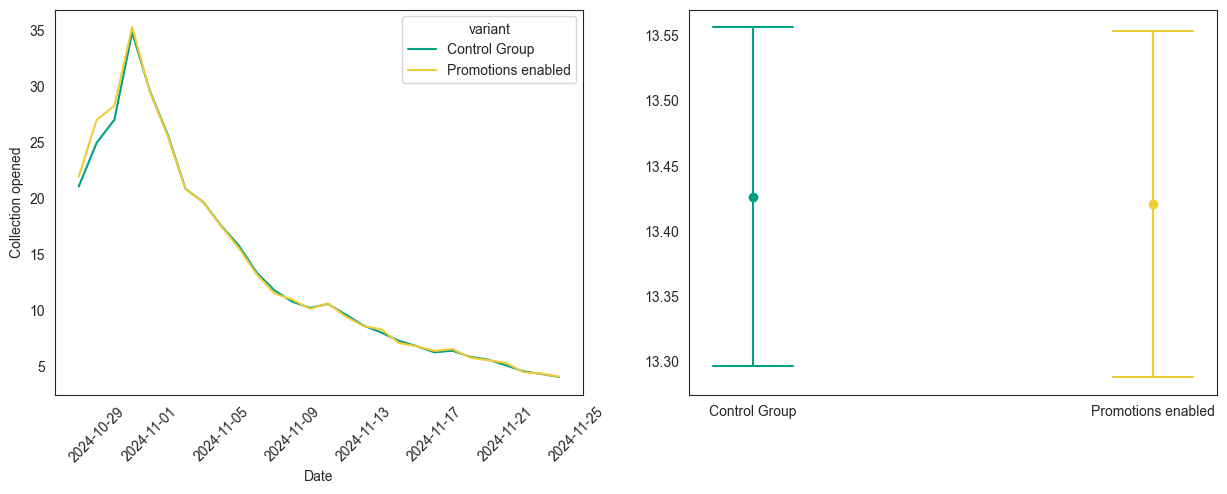

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DISTINCT COLLECTION OPENED PER SESSION                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,10.123146,10.206693,0.083547,-0.054336,0.221429,0.109913,0.052263,False


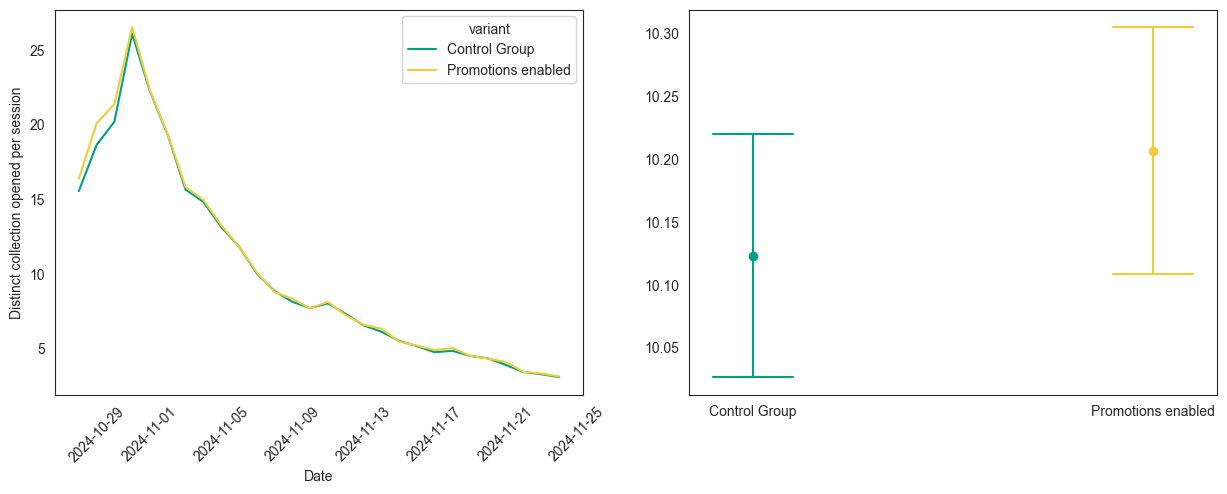

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ CVR                                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.252986,0.25341,0.000424,-0.00161,0.002459,0.582004,0.000771,False


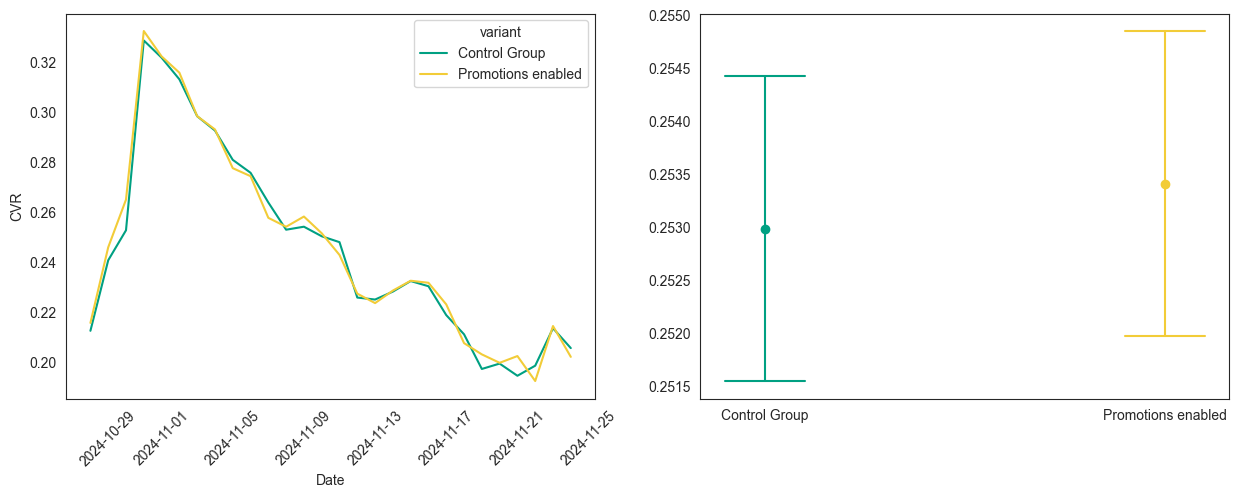

In [28]:
### Orders and GMV
from glovo_experimentation_analytics.analytics.experiment import Experiment

df['date'] = pd.to_datetime(df['first_exposure_at'])

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "New surfacing promotions will increase the number of customers that interact with Promotions",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Collection_Shoppable_Banner impressions",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "banner_impressions",
            },   
            {
                "metric_name": "Distinct Collection_Shoppable_Banner impressions per session",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "distinct_banner_impressions_per_session",
            },
            {
                "metric_name": "Widget collection impresions",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "widget_collection_impressions",
            },  
            {
                "metric_name": "Collection opened",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "collection_opened",
            },   
            {
                "metric_name": "Distinct collection opened per session",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "distinct_collection_opened_per_session",
            },   
            {
                "metric_name": "CVR",
                "df": df,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "cvr",
            },   
        ],    
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": True
    }

exp_fin = Experiment.from_dict(experiment_config)
exp_fin.full_analysis()

## Only Customers with orders

In [33]:
cond = df['order_created_session'] > 0
df_with_orders = df[cond].copy()
df_with_orders

,customer_id,variant,first_exposure_at,banner_impressions,distinct_banner_impressions_per_session,widget_collection_impressions,collection_opened,distinct_collection_opened_per_session,store_access_session,order_created_session,cvr,date
1,134756641,Control Group,2024-11-05,42,17,0,79,56,14,9,0.642857,2024-11-05
2,39995464,Control Group,2024-11-01,32,13,0,118,87,13,6,0.461538,2024-11-01
4,31796901,Promotions enabled,2024-11-01,8,3,16,46,33,5,3,0.600000,2024-11-01
7,109046319,Promotions enabled,2024-11-04,49,28,81,242,169,33,11,0.333333,2024-11-04
8,15016743,Promotions enabled,2024-11-12,10,7,6,40,32,4,1,0.250000,2024-11-12
...,...,...,...,...,...,...,...,...,...,...,...,...
958409,41557715,Promotions enabled,2024-11-13,2,1,0,5,5,1,1,1.000000,2024-11-13
958410,54140636,Control Group,2024-11-23,1,1,0,9,9,1,1,1.000000,2024-11-23
958414,132274633,Promotions enabled,2024-11-20,0,0,0,17,10,1,1,1.000000,2024-11-20
958416,27572861,Promotions enabled,2024-11-09,0,0,0,0,0,1,1,1.000000,2024-11-09


In [34]:
# Customer split
df_with_orders.groupby('variant')[['customer_id']].agg(['nunique']).\
    assign(perc= lambda x: x[('customer_id','nunique')]/df_with_orders['customer_id'].nunique())

,customer_id,perc
,nunique,
variant,,
Control Group,174582,0.499837
Promotions enabled,174696,0.500163


                                              Experiment Information                                               
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━━━━━━━━┓
┃              ┃              ┃               ┃              ┃               ┃             ┃       ┃        Alpha ┃
┃ Name         ┃ Hypothesis   ┃          Date ┃      Metrics ┃      Variants ┃ Compare all ┃ Alpha ┃    corrected ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━━━━━━━━┩
│ Surfacing    │ New          │ 2024-07-04 to │ ['Collectio… │     ['Control │        True │  0.05 │       0.0083 │
│ promos for   │ surfacing    │    2024-08-16 │ impressions… │       Group', │             │       │              │
│ Groceries    │ promotions   │               │    'Distinct │   'Promotions │             │       │              │
│              │ will         │               │ Collection_… │     enabled'] │             │       │              │
│              │ increase the │               │  impressions │               │             │       │              │
│              │ number of    │               │          per │               │             │       │              │
│              │ customers    │               │    session', │               │             │       │              │
│              │ that         │               │      'Widget │               │             │       │              │
│              │ interact     │               │   collection │               │             │       │              │
│              │ with         │               │ impresions', │               │             │       │              │
│              │ Promotions   │               │  'Collection │               │             │       │              │
│              │              │               │     opened', │               │             │       │              │
│              │              │               │    'Distinct │               │             │       │              │
│              │              │               │   collection │               │             │       │              │
│              │              │               │   opened per │               │             │       │              │
│              │              │               │    session', │               │             │       │              │
│              │              │               │       'CVR'] │               │             │       │              │
└──────────────┴──────────────┴───────────────┴──────────────┴───────────────┴─────────────┴───────┴──────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ COLLECTION_SHOPPABLE_BANNER IMPRESSIONS                                                                         │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,6.477054,6.42764,-0.049414,-0.172168,0.07334,0.288229,0.046528,False


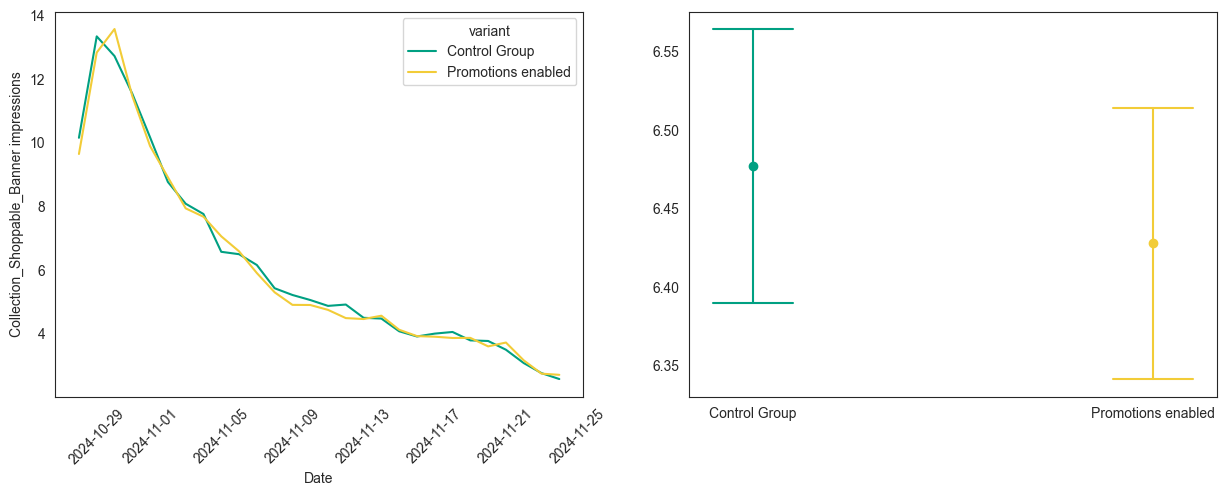

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DISTINCT COLLECTION_SHOPPABLE_BANNER IMPRESSIONS PER SESSION                                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,2.818057,2.814243,-0.003814,-0.050408,0.04278,0.829028,0.017661,False


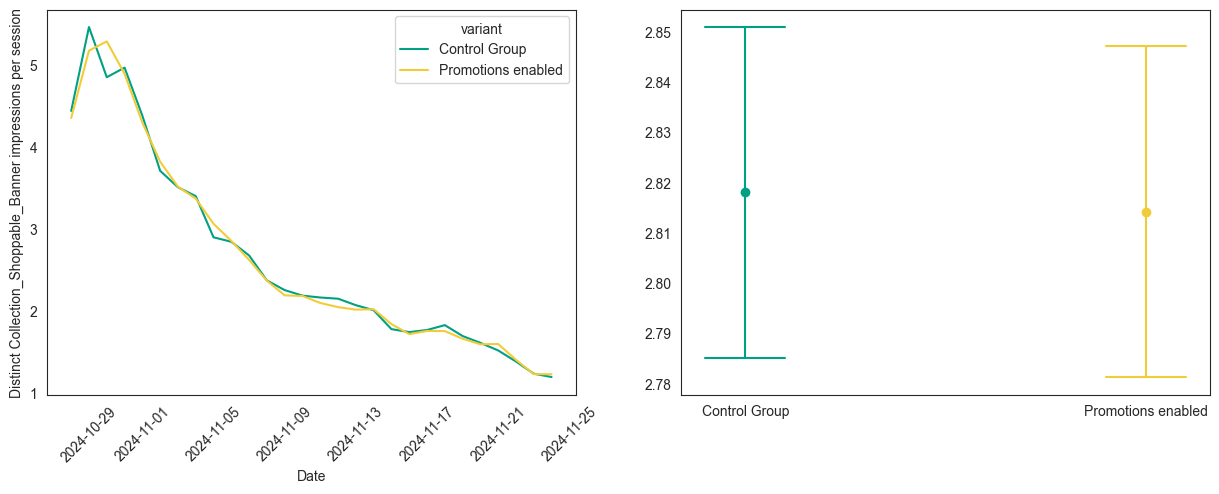

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ WIDGET COLLECTION IMPRESIONS                                                                                    │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.000853,10.685517,10.684663,10.551441,10.817885,0.0,0.050496,True


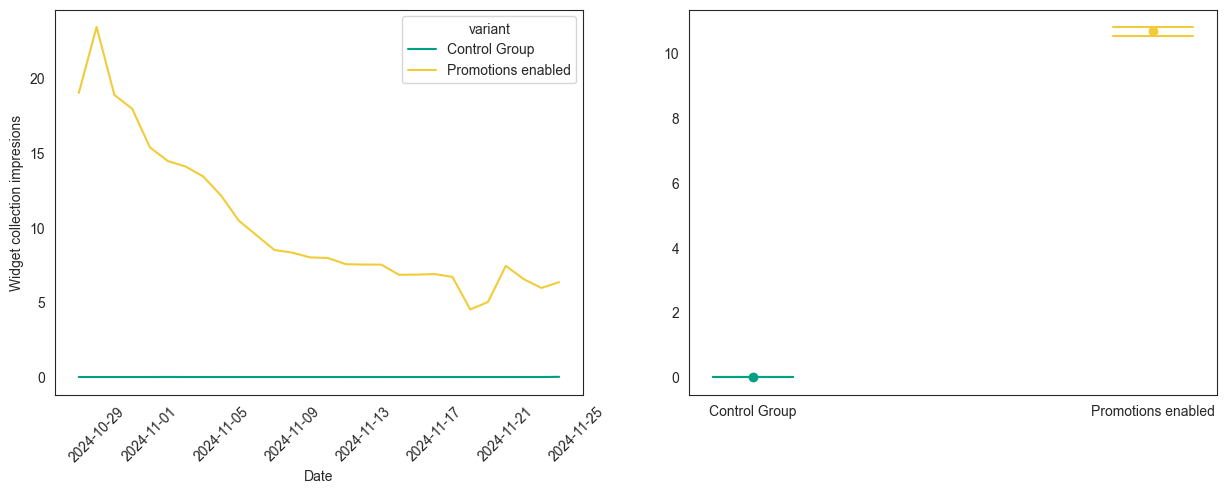

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ COLLECTION OPENED                                                                                               │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,29.132694,29.100117,-0.032577,-0.484163,0.419008,0.849055,0.171167,False


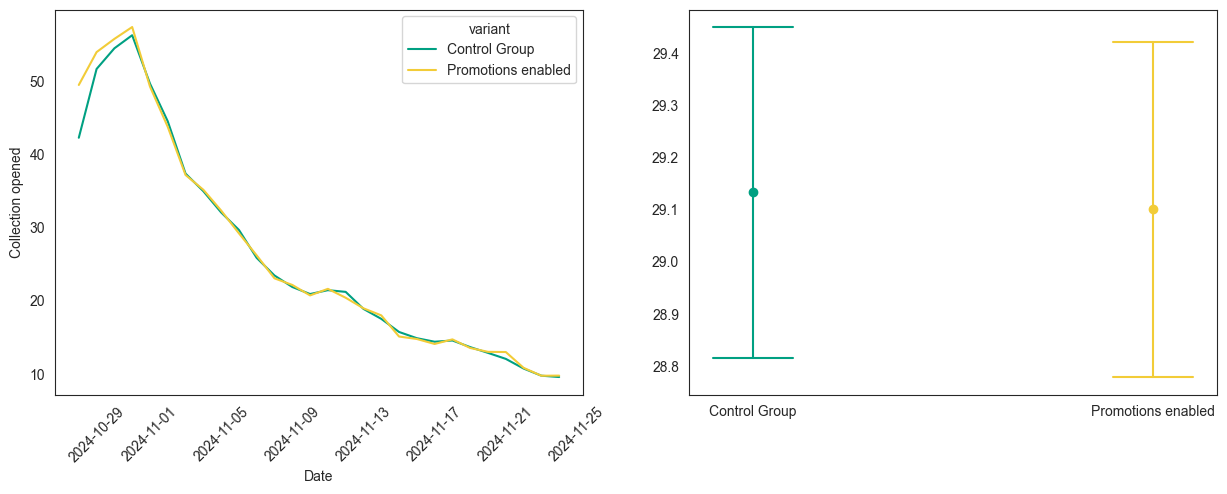

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ DISTINCT COLLECTION OPENED PER SESSION                                                                          │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,21.751395,21.903976,0.152581,-0.18252,0.487683,0.229643,0.127015,False


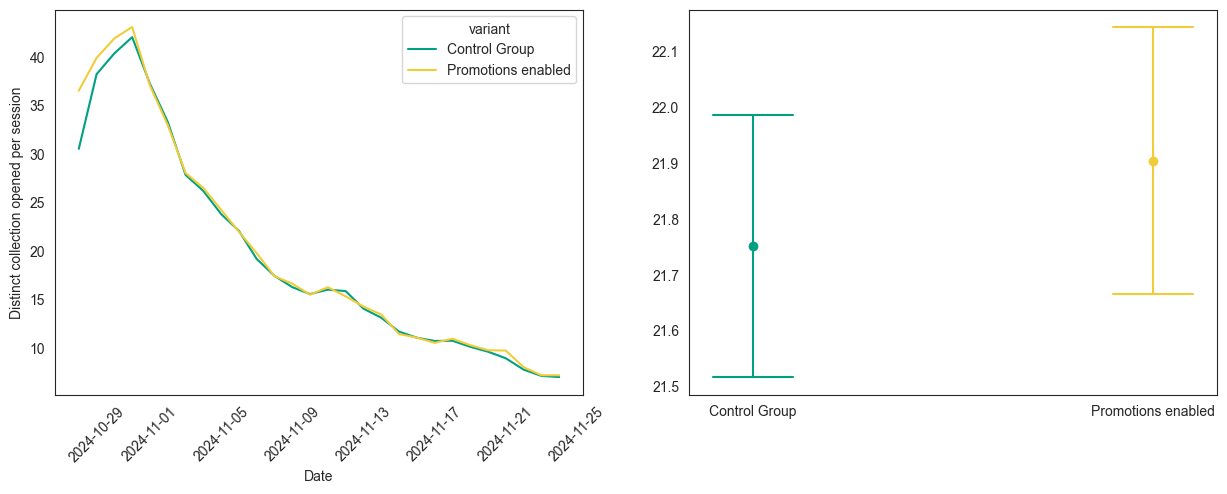

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ CVR                                                                                                             │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

,variant 1,variant 2,lift,lower_limit,upper_limit,p-value,standard_error,significant
Control Group-Promotions enabled,0.69488,0.694673,-0.000207,-0.002796,0.002383,0.833355,0.000982,False


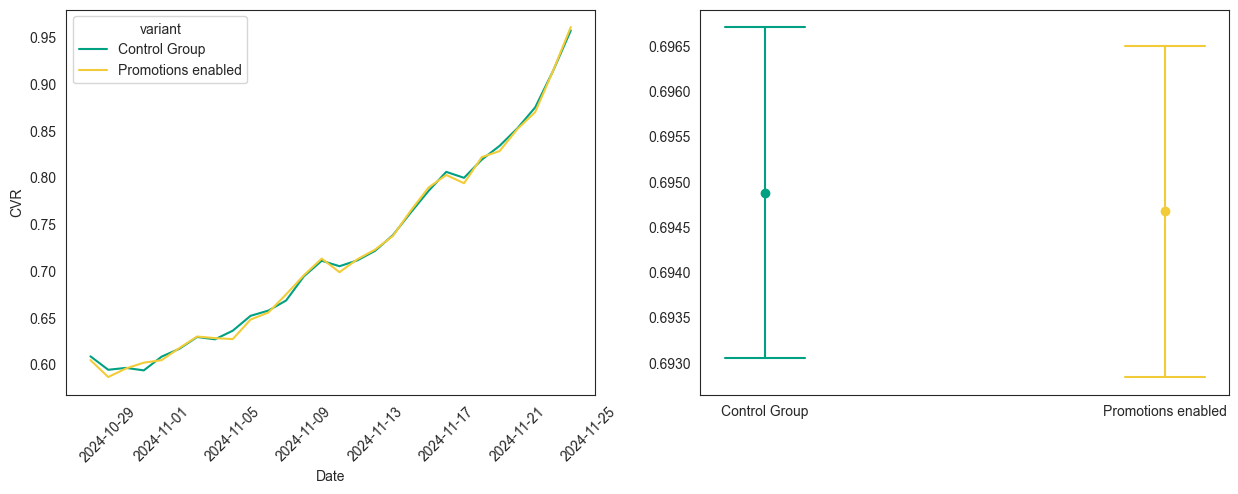

In [35]:
### Orders and GMV
from glovo_experimentation_analytics.analytics.experiment import Experiment

df['date'] = pd.to_datetime(df['first_exposure_at'])

experiment_config = {
        "name": "Surfacing promos for Groceries",
        "hypothesis": "New surfacing promotions will increase the number of customers that interact with Promotions",
        "start_date": "2024-07-04",
        "end_date": "2024-08-16",
        "treatment_col": "variant",
        "metrics": [
            {
                "metric_name": "Collection_Shoppable_Banner impressions",
                "df": df_with_orders,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "banner_impressions",
            },   
            {
                "metric_name": "Distinct Collection_Shoppable_Banner impressions per session",
                "df": df_with_orders,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "distinct_banner_impressions_per_session",
            },
            {
                "metric_name": "Widget collection impresions",
                "df": df_with_orders,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "widget_collection_impressions",
            },  
            {
                "metric_name": "Collection opened",
                "df": df_with_orders,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "collection_opened",
            },   
            {
                "metric_name": "Distinct collection opened per session",
                "df": df_with_orders,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "distinct_collection_opened_per_session",
            },   
            {
                "metric_name": "CVR",
                "df": df_with_orders,
                "analysis_type": "ttest",
                "cluster_cols" : ["customer_id"],
                "metric_col": "cvr",
            },   
        ],    
        "variants": [
            {"name": "Control Group", "description": "Control", "control": True},
            {"name": "Promotions enabled", "description": "Promotions enabled", "control": False}
        ],
        "alpha": 0.05,
        "correction_method": "bonferroni",
        "compare_all": True
    }

exp_fin = Experiment.from_dict(experiment_config)
exp_fin.full_analysis()